In [95]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
# preproceessing
from model_transformers import FeaturesInteractions,SkewTransformer,ZeroThreshold

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import RepeatedKFold,GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler

# sklearn classes
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


In [96]:
#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [97]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)     

# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

# Drop outliers
train = train.drop(train[(train['van_der_waals_change']>3)].index)
train = train.drop(train[(train['dg_change'].abs()>8)].index)

y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

# Modelling

#### Crossvalidation strategy

In [98]:
#Validation function
n_folds = 10

def evaluating(model,train,target):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, train, target, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1)
    return(cvscore)

In [99]:
# preprocess pipeline steps
#steps pipeline
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

#### algorithms

In [140]:
#lasso model
lasso = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=True,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly'))

svrRBF = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=2.5,epsilon=0.5,gamma=0.5,kernel='rbf'))

gbt = make_pipeline(interactions,skewness,zeroth,
                   GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=7, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=2, 
                                   loss='huber', random_state =5))


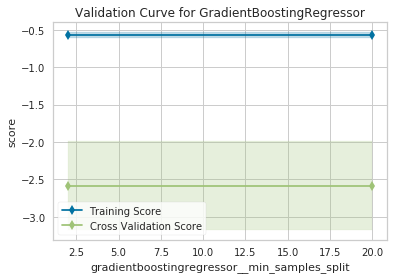

0


In [142]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
#2)
#3) Crear pipeline

viz = ValidationCurve(
    gbt, njobs=-1,param_name="gradientboostingregressor__min_samples_split",
    param_range=[2,20], cv=10, scoring="neg_mean_squared_error"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()
print(viz.test_scores_mean_.argmax())

In [120]:
viz.test_scores_mean_.argmax()

2

#### Base model scores

In [57]:

score = evaluating(lasso,X_train,y_train)

print("Lasso RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("Lasso r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Lasso RMSE test: 1.7254 (0.1935)

Lasso r2 test: 0.1443 (0.0643)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


In [58]:
score = evaluating(svrP,X_train,y_train)

print("SVRpoly RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("SVRpoly r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


SVRpoly RMSE test: 1.7139 (0.1858)

SVRpoly r2 test: 0.1532 (0.0861)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


In [59]:
score = evaluating(svrRBF,X_train,y_train)

print("SVRpoly RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("SVRpoly r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


SVRpoly RMSE test: 1.6718 (0.1876)

SVRpoly r2 test: 0.1965 (0.0544)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


In [60]:
score = evaluating(gbt,X_train,y_train)

print("GBT RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("GBT r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


GBT RMSE test: 1.6364 (0.1677)

GBT r2 test: 0.2259 (0.0886)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [61]:

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [62]:
averaged_models = AveragingModels(models = (gbt, svrP, svrRBF, lasso))
score = evaluating(averaged_models,X_train,y_train)

print("AvgModels RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("AvgModels r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AvgModels RMSE test: 1.6465 (0.1865)

AvgModels r2 test: 0.2201 (0.0696)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


In [63]:
score

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([19.35805273, 18.59030914, 18.72346807, 18.78415751, 23.37512088,
        23.20317268, 23.69950247, 24.017349  , 13.43977284, 13.72295785]),
 'score_time': array([0.6581378 , 0.62601638, 0.60309696, 0.62023902, 0.7596817 ,
        0.78167152, 0.71052575, 0.6674521 , 0.30461764, 0.29918885]),
 'test_r2': array([0.28711063, 0.23162478, 0.16073508, 0.24267324, 0.12215413,
        0.24343217, 0.22777803, 0.26330729, 0.32844165, 0.09391126]),
 'train_r2': array([0.56894758, 0.57744922, 0.57194507, 0.57179831, 0.58447763,
        0.57050101, 0.5741025 , 0.56155252, 0.56656689, 0.57360696]),
 'test_neg_mean_squared_error': array([-1.75210324, -3.02438101, -3.02912364, -2.58254321, -2.70116561,
        -2.77777235, -2.52484721, -3.8930388 , -1.84650175, -3.32539817]),
 'train_neg_mean_squared_error': array([-1.57412721, -1.47200478, -1.50902623, -1.51967848, -1.48931435,
        -1.51159328, -1.51586054, -1.46459479, -1.57009432, -1.49839522])}

In [71]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [80]:
lassoMeta = make_pipeline(MinMaxScaler(), Lasso(alpha =0.0005, random_state=1,normalize=True,fit_intercept=True))


In [81]:
stacked_averaged_models = StackingAveragedModels(base_models = (gbt, svrP, svrRBF),
                                                 meta_model = lassoMeta)

In [82]:
score = evaluating(stacked_averaged_models,X_train,y_train)

print("StackedModels RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("StackedModels r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


StackedModels RMSE test: 1.6199 (0.1879)

StackedModels r2 test: 0.2456 (0.0648)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


In [85]:
stacked_averaged_models.fit(X_train,y_train)

StackingAveragedModels(base_models=(Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interact..., epsilon=0.5, gamma=0.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])),
            meta_model=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))]),
            n_folds=5)

In [88]:
stacked_test_pred = stacked_averaged_models.predict(X_test)
np.sqrt(mean_squared_error(y_test, stacked_test_pred))

1.6240816601794663

In [89]:
r2_score(y_test,stacked_test_pred)

0.3350569123967073

In [91]:
np.corrcoef(stacked_test_pred,y_test.values.ravel())[0][1]

0.5991021227724717

In [92]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [93]:
final_stacked_averaged_models = stacked_averaged_models.fit(full_data,y_full)

In [94]:
from sklearn.externals import joblib

# save final model

joblib.dump(final_stacked_averaged_models, 'stacked_averaged_models_FINAL.pkl')

['stacked_averaged_models_FINAL.pkl']